In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.api import add_constant

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "40g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

25/01/03 08:43:43 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/01/03 08:43:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/03 08:43:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# base_path = "/data/saturation/thesis_run_20240726_single_sims/"
# base_path = "/data/saturation/thesis_run_20240929/"
# base_path = "/data/saturation/thesis_run_20241203/"
base_path = "/data/saturation/thesis_run_20250102/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_df = create_configs_df(
    read_configs(
        base_path,
        spark,
        completed_only=False
    )
)
configs_pdf = configs_df.toPandas()

configs_pdf = configs_pdf[~configs_pdf.simulation_id.isna()].copy()
configs_pdf["rim_erasure_exponent"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("exponent", -1))
configs_pdf["rim_erasure_radius_ratio"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("ratio", -1))

In [5]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

In [6]:
def get_statistics_with_lifespans_for_simulations(
    simulation_ids: List[int],
    base_path: str,
    configs_df: DataFrame,
    spark: SparkSession,
    n_samples_per_sim: int
) -> pd.DataFrame:
    F.broadcast(configs_df).createOrReplaceTempView("configs")
    
    results = []
    
    for simulation_id in simulation_ids:
        craters = spark.read.parquet(f"{base_path}/{simulation_id}/craters_*.parquet")
        removals = spark.read.parquet(f"{base_path}/{simulation_id}/crater_removals_*.parquet")
        statistics_for_simulation = spark.read.parquet(f"{base_path}/{simulation_id}/statistics_*.parquet")

        max_n = statistics_for_simulation.select(F.max("ntot")).collect()[0][0]

        statistics_for_simulation.createOrReplaceTempView("statistics")
        craters.createOrReplaceTempView("craters")
        removals.createOrReplaceTempView("removals")
        
        query = f"""
        SELECT
            c.x,
            c.y,
            c.radius,
            s.simulation_id,
            s.ntot,
            s.nobs,
            s.areal_density,
            s.z,
            s.za,
            configs.slope,
            configs.mrp,
            configs.rmult,
            configs.rim_erasure_method['name'] AS rim_erasure_method_name,
            COALESCE(configs.rim_erasure_method['ratio'], 0) AS rim_erasure_radius_ratio,
            COALESCE(configs.rim_erasure_method['exponent'], 0) AS rim_erasure_exponent,
            CASE
                WHEN r.removed_by_crater_id IS NULL THEN NULL
                ELSE r.removed_by_crater_id - c.id
            END AS lifespan
        FROM
            statistics s
            INNER JOIN craters c ON
                c.id = s.crater_id
            INNER JOIN removals r ON
                r.removed_crater_id = c.id
            INNER JOIN configs ON
                configs.simulation_id = s.simulation_id
        WHERE
            s.ntot <= {int(max_n * 0.75)}
        """
        result_for_simulation = spark.sql(query)
        results_count = result_for_simulation.count()
        result_for_simulation = result_for_simulation.sample((n_samples_per_sim * 1.1) / results_count)
        results.append(result_for_simulation.limit(n_samples_per_sim).toPandas())
    
    return pd.concat(results, axis=0)

In [7]:
def get_statistics_with_censored_lifespans_for_simulations(
    simulation_ids: List[int],
    base_path: str,
    configs_df: DataFrame,
    spark: SparkSession,
    n_samples_per_sim: int
) -> pd.DataFrame:
    F.broadcast(configs_df).createOrReplaceTempView("configs")
    
    results = []
    
    for simulation_id in simulation_ids:
        craters = spark.read.parquet(f"{base_path}/{simulation_id}/craters_*.parquet")
        removals = spark.read.parquet(f"{base_path}/{simulation_id}/crater_removals_*.parquet")
        statistics_for_simulation = spark.read.parquet(f"{base_path}/{simulation_id}/statistics_*.parquet")

        craters.createOrReplaceTempView("craters")
        removals.createOrReplaceTempView("removals")
        statistics_for_simulation.createOrReplaceTempView("statistics")

        max_crater_id = craters.select(F.max("id")).collect()[0][0]
        
        query = f"""
        SELECT
            c.x,
            c.y,
            c.radius,
            s.simulation_id,
            s.ntot,
            s.nobs,
            s.areal_density,
            s.z,
            s.za,
            configs.slope,
            configs.mrp,
            configs.rmult,
            configs.rim_erasure_method['name'] AS rim_erasure_method_name,
            COALESCE(configs.rim_erasure_method['ratio'], 0) AS rim_erasure_radius_ratio,
            COALESCE(configs.rim_erasure_method['exponent'], 0) AS rim_erasure_exponent,
            COALESCE(r.removed_by_crater_id, {max_crater_id}) - c.id AS lifespan,
            CASE WHEN r.removed_by_crater_id IS NOT NULL THEN 1 ELSE 0 END AS event
        FROM
            statistics s
            INNER JOIN craters c ON
                c.id = s.crater_id
            LEFT JOIN removals r ON
                r.removed_crater_id = c.id
            INNER JOIN configs ON
                configs.simulation_id = s.simulation_id
        """
        result_for_simulation = spark.sql(query)
        results_count = result_for_simulation.count()
        result_for_simulation = result_for_simulation.sample((n_samples_per_sim * 1.1) / results_count)
        results.append(result_for_simulation.limit(n_samples_per_sim).toPandas())
    
    return pd.concat(results, axis=0)

# Comparisons of scenarios

### Negative Binomial Model

In [8]:
configs_pdf

,mrp,r_min,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio
0,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.1}",1.0,12.0,-2.8,125.0,1000.0,0.1,2.0
1,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.6}",1.0,122.0,-1.8,125.0,1000.0,0.6,2.0
2,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.7}",1.0,141.0,-2.2,125.0,1000.0,0.7,2.0
3,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.2}",1.0,28.0,-3.8,125.0,1000.0,0.2,2.0
4,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.4}",1.0,74.0,-3.0,125.0,1000.0,0.4,2.0
...,...,...,...,...,...,...,...,...,...,...
206,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.8}",1.0,159.0,-2.8,125.0,1000.0,0.8,2.0
207,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.4}",1.0,69.0,-4.0,125.0,1000.0,0.4,2.0
208,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.7}",1.0,131.0,-4.2,125.0,1000.0,0.7,2.0
209,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.9}",1.0,183.0,-2.2,125.0,1000.0,0.9,2.0


In [9]:
max_slope = -1
selected_simulation_ids = list(configs_pdf[(configs_pdf.slope <= max_slope) & configs_pdf.rim_erasure_exponent.between(0, 1.1) & (configs_pdf.rmult == 1.0)].simulation_id.astype("int"))
len(selected_simulation_ids)

210

In [20]:
df = get_statistics_with_lifespans_for_simulations(
    selected_simulation_ids,
    base_path,
    configs_df,
    spark,
    n_samples_per_sim=100000
)
df

,x,y,radius,simulation_id,ntot,nobs,areal_density,z,za,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,973.351440,278.065643,7.668154,12,191673,2064,0.0,-86.913198,-86.913198,-2.8,0.5,1.0,NaN,2.0,0.1,473347
1,348.576721,1079.734009,9.559514,12,191680,2062,0.0,-86.871079,-86.871079,-2.8,0.5,1.0,NaN,2.0,0.1,515195
2,950.585632,913.549316,11.684835,12,191688,2063,0.0,-86.892141,-86.892141,-2.8,0.5,1.0,NaN,2.0,0.1,27433
3,261.138275,1069.479248,7.514760,12,191689,2062,0.0,-86.871079,-86.871079,-2.8,0.5,1.0,NaN,2.0,0.1,179626
4,282.696564,1061.843506,3.330577,12,191692,2064,0.0,-86.913198,-86.913198,-2.8,0.5,1.0,NaN,2.0,0.1,258614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,312.780731,761.996216,6.240954,37,253548,3208,0.0,-108.354777,-108.354777,-2.0,0.5,1.0,NaN,2.0,0.2,135537
99996,735.728455,1121.564697,7.503336,37,253554,3208,0.0,-108.354777,-108.354777,-2.0,0.5,1.0,NaN,2.0,0.2,242669
99997,777.307678,358.024475,4.181595,37,253559,3213,0.0,-108.439185,-108.439185,-2.0,0.5,1.0,NaN,2.0,0.2,275799
99998,590.119873,217.875031,7.278336,37,253560,3212,0.0,-108.422309,-108.422309,-2.0,0.5,1.0,NaN,2.0,0.2,245294


In [21]:
models_by_sim_id = dict()

for simulation_id in df.simulation_id.drop_duplicates():
    d = df[df.simulation_id == simulation_id]

    # Fit a negative binomial model
    model = smf.negativebinomial(data=d, formula="lifespan ~ 1 + np.log(radius)").fit(maxiter=1000, method="bfgs", cov_type="HC0")
    # model = smf.ols(data=d, formula="np.log(lifespan) ~ 1 + np.log(radius)").fit()
    models_by_sim_id[simulation_id] = model

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 13.491489
         Iterations: 9
         Function evaluations: 60
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 12.305515
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 13.430718
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 13.962474
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.124408
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.882599
         Iterations: 10
         Function evaluations: 67
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: 12.278858
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 15.356130
         Iterations: 13
         Function evaluations: 38
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 11.574233
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 14.762274
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 10.029942
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
O

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.840181
         Iterations: 13
         Function evaluations: 112
         Gradient evaluations: 100


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.850350
         Iterations: 12
         Function evaluations: 76
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: 14.878270
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.109347
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 11.586130
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.748068
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.603791
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Opti

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.241019
         Iterations: 13
         Function evaluations: 78
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 9.190972
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 9.225972
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 13.611430
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 14.273019
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 16.531382
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14
Optimi

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.473458
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 16.365503
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 9.192567
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 16.875121
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.124869
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 14.285988
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Op

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 16.954601
         Iterations: 9
         Function evaluations: 71
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 13.739421
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 13.461062
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.479389
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.648564
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 10.835316
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.128372
         Iterations: 12
         Function evaluations: 47
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 11.619838
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 10.821631
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 12.230733
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 13.176687
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 14.293584
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Opti

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 13.862750
         Iterations: 13
         Function evaluations: 86
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: 13.554937
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 17.813735
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 10.044799
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.939059
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 15.549337
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.332744
         Iterations: 11
         Function evaluations: 112
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: 12.912323
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 16.924612
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 16.737376
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.992978
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.114697
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
O

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.569306
         Iterations: 11
         Function evaluations: 75
         Gradient evaluations: 64


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.470884
         Iterations: 11
         Function evaluations: 45
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 13.807946
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 17.166678
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 13.728679
         Iterations: 10
         Function evaluations: 84
         Gradient evaluations: 72


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 13.672541
         Iterations: 10
         Function evaluations: 57
         Gradient evaluations: 45


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.107033
         Iterations: 10
         Function evaluations: 32
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 12.700420
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.049302
         Iterations: 9
         Function evaluations: 71
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 13.744279
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.027540
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 13.412444
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 14.252385
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.300055
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optim

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.172765
         Iterations: 8
         Function evaluations: 56
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 14.568979
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 14.087754
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 10.902585
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.741544
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.780335
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
O

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 13.697793
         Iterations: 9
         Function evaluations: 84
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 14.313691
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 16.149207
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 13.661873
         Iterations: 11
         Function evaluations: 118
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: 14.218033
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.550777
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.749363
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 17.592431
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 11.631693
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 1

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.468800
         Iterations: 11
         Function evaluations: 55
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 14.197596
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 12.797380
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 12.255374
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.133195
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 11.581521
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 13.913092
         Iterations: 7
         Function evaluations: 44
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: 10.051565
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 9.198370
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.473108
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.116352
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 14.011324
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Op

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 16.739374
         Iterations: 11
         Function evaluations: 87
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: 14.039254
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 14.533569
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.861404
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.653188
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.333297
         Iterations: 14
         Function evaluations: 51
         Gradient evaluations: 49
O

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 16.021664
         Iterations: 11
         Function evaluations: 103
         Gradient evaluations: 85
Optimization terminated successfully.
         Current function value: 13.811171
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.657181
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.231086
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 12.396796
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 15.024985
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 17.371982
         Iterations: 11
         Function evaluations: 33
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 9.214981
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.966147
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.916248
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 12.874806
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.840843
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Op

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.607243
         Iterations: 10
         Function evaluations: 75
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 13.581023
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.709301
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.691856
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 10.843245
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 12.769076
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.461475
         Iterations: 12
         Function evaluations: 123
         Gradient evaluations: 109
Optimization terminated successfully.
         Current function value: 14.499163
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.613047
         Iterations: 6
         Function evaluations: 62
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 14.751202
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 10.842555
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 16.303045
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 11.627726
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 12.358417
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Opt

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.601913
         Iterations: 10
         Function evaluations: 57
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 14.666991
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 15.817074
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 13.546035
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 12.740102
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10


In [22]:
data_to_plot = configs_pdf[configs_pdf.simulation_id.isin(models_by_sim_id.keys())].copy()
data_to_plot["fitted_slope"] = [models_by_sim_id[simulation_id].params.iloc[1] for simulation_id in models_by_sim_id.keys()]
data_to_plot["fitted_slope_std_err"] = [models_by_sim_id[simulation_id].bse.iloc[1] for simulation_id in models_by_sim_id.keys()]
data_to_plot

,mrp,r_min,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio,fitted_slope,fitted_slope_std_err
0,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.1}",1.0,12.0,-2.8,125.0,1000.0,0.1,2.0,0.032120,0.003297
1,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.6}",1.0,122.0,-1.8,125.0,1000.0,0.6,2.0,0.006421,0.004319
2,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.7}",1.0,141.0,-2.2,125.0,1000.0,0.7,2.0,0.174626,0.004703
3,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.2}",1.0,28.0,-3.8,125.0,1000.0,0.2,2.0,0.338960,0.003751
4,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.4}",1.0,74.0,-3.0,125.0,1000.0,0.4,2.0,0.366354,0.003972
...,...,...,...,...,...,...,...,...,...,...,...,...
206,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.8}",1.0,159.0,-2.8,125.0,1000.0,0.8,2.0,0.629595,0.005205
207,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.4}",1.0,69.0,-4.0,125.0,1000.0,0.4,2.0,0.784937,0.004495
208,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.7}",1.0,131.0,-4.2,125.0,1000.0,0.7,2.0,1.529643,0.005847
209,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.9}",1.0,183.0,-2.2,125.0,1000.0,0.9,2.0,0.272670,0.005130


In [23]:
data_to_plot[["simulation_id", "slope", "rim_erasure_exponent"]].sort_values(["rim_erasure_exponent", "slope"])

,simulation_id,slope,rim_erasure_exponent
101,1.0,-5.0,0.1
95,2.0,-4.8,0.1
90,3.0,-4.6,0.1
190,4.0,-4.4,0.1
122,5.0,-4.2,0.1
...,...,...,...
168,206.0,-1.8,1.0
119,207.0,-1.6,1.0
108,208.0,-1.4,1.0
22,209.0,-1.2,1.0


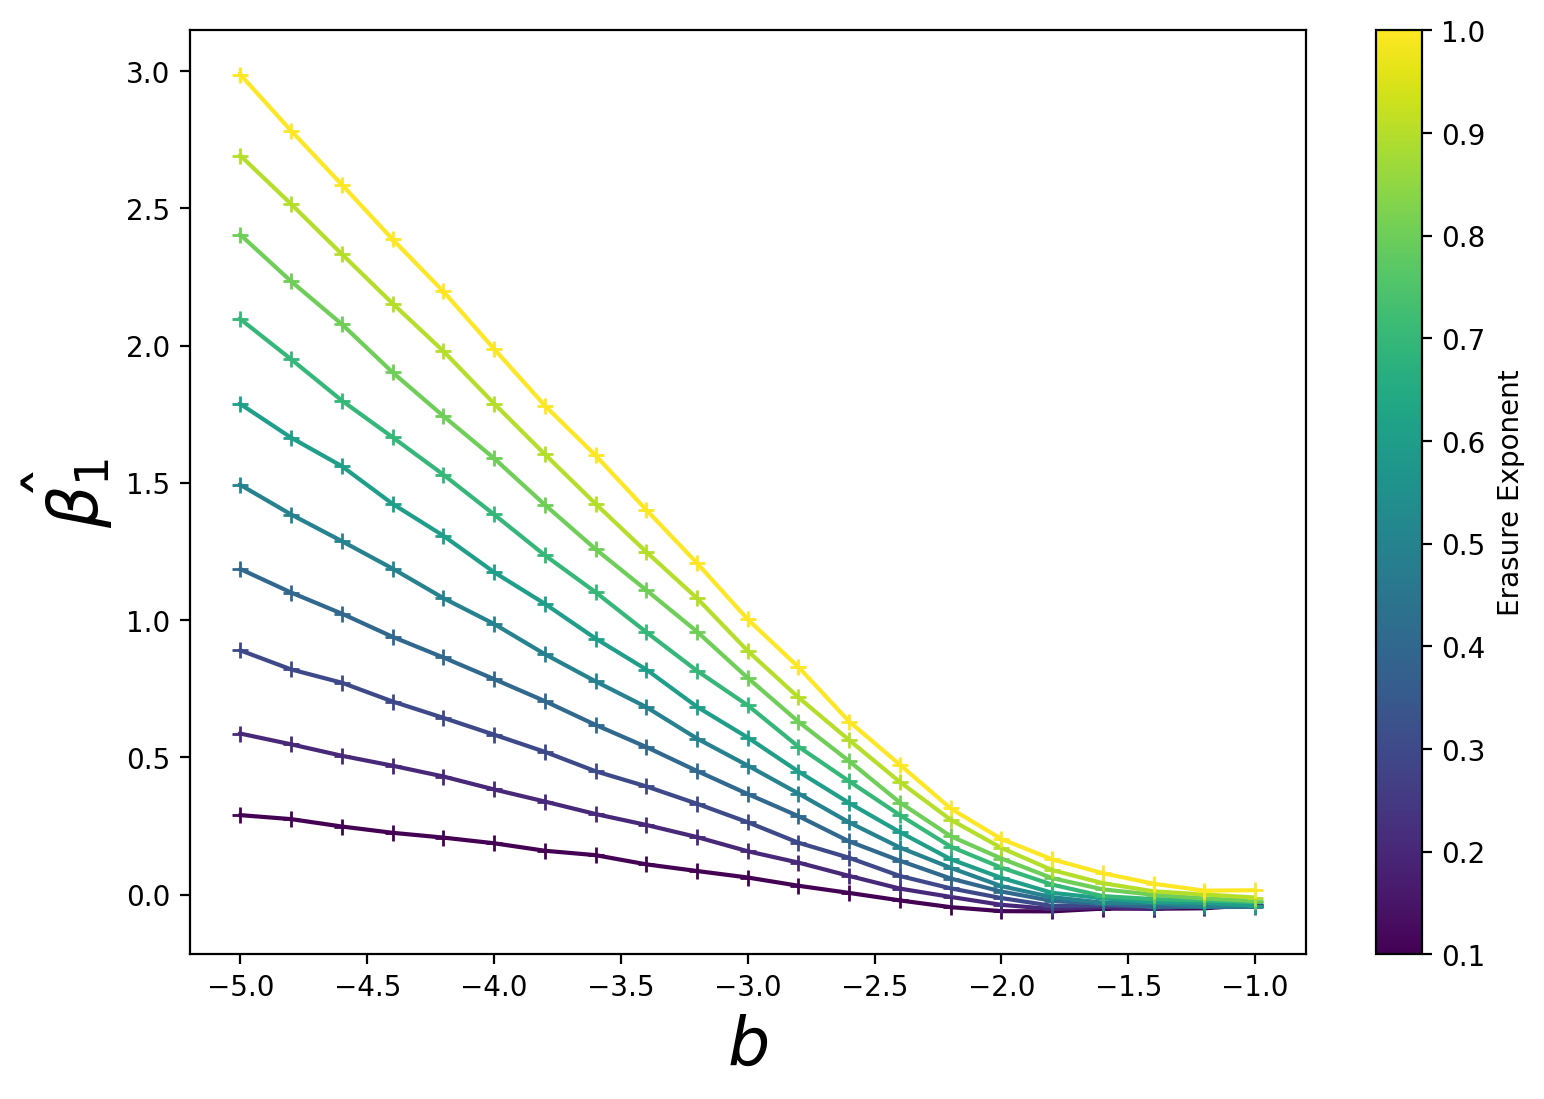

In [28]:
fig = plt.figure(figsize=(9, 6), dpi=200)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(data_to_plot["rim_erasure_exponent"].min(), data_to_plot["rim_erasure_exponent"].max())

for rim_erasure_exponent in data_to_plot.rim_erasure_exponent.drop_duplicates().sort_values():
    d = data_to_plot[data_to_plot.rim_erasure_exponent == rim_erasure_exponent].sort_values("slope").copy()
    ax.errorbar(
        d.slope,
        d.fitted_slope,
        d.fitted_slope_std_err,
        marker="+",
        color=cm.viridis(norm(rim_erasure_exponent)),
        ecolor=cm.viridis(norm(rim_erasure_exponent))
    )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Erasure Exponent')

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\beta_1}$", fontsize=font_size)

plt.show()

### Diagnostics on best model across slopes (-3, -5)

In [347]:
# Best model so far
max_slope = -2.99
min_slope = -5.01
data = df[(df.slope.between(min_slope, max_slope))].copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 15.179494
         Iterations: 35
         Function evaluations: 71
         Gradient evaluations: 70
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:             11000000
Model:               NegativeBinomial   Df Residuals:                 10999995
Method:                           MLE   Df Model:                            4
Date:                Fri, 03 Jan 2025   Pseudo R-squ.:                 0.06236
Time:                        19:41:55   Log-Likelihood:            -1.6697e+08
converged:                       True   LL-Null:                   -1.7808e+08
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

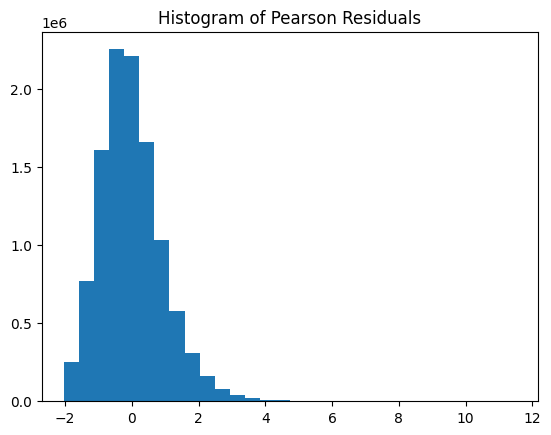

In [348]:
residuals = model.resid_pearson
plt.hist(residuals, bins=30)
plt.title("Histogram of Pearson Residuals")
plt.show()

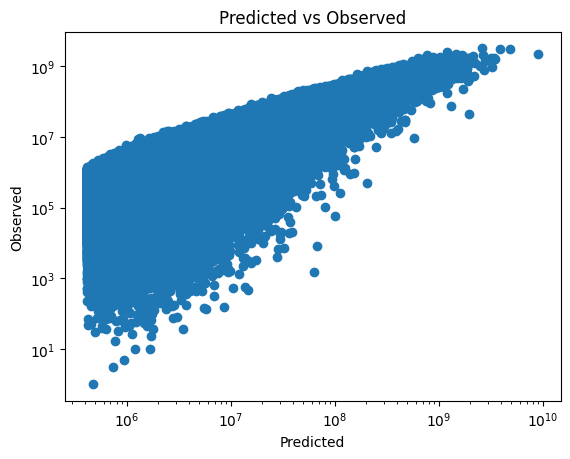

In [349]:
predicted = model.predict()
plt.scatter(predicted, model.model.endog)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Predicted vs Observed")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [350]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white


# Extract Pearson residuals
pearson_residuals = model.resid_pearson

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(pearson_residuals, model.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

print("Breusch-Pagan Test:")
print(dict(zip(bp_labels, bp_test)))

# Perform the White test
white_test = het_white(pearson_residuals, model.model.exog)
white_labels = ['Test Statistic', 'p-value', 'f-value', 'f p-value']

print("\nWhite Test:")
print(dict(zip(white_labels, white_test)))

# Interpretation:
# A small p-value (e.g., < 0.05) suggests evidence of heteroscedasticity.

Breusch-Pagan Test:
{'Lagrange multiplier statistic': np.float64(327590.21220404893), 'p-value': np.float64(0.0), 'f-value': np.float64(84411.36462952619), 'f p-value': np.float64(0.0)}

White Test:
{'Test Statistic': np.float64(341839.3936464564), 'p-value': np.float64(0.0), 'f-value': np.float64(27138.674321879625), 'f p-value': np.float64(0.0)}


In [351]:
model.model.exog_names

['Intercept',
 'slope:rim_erasure_exponent:np.log(radius)',
 'rim_erasure_exponent:np.log(radius)',
 'np.log(-slope)',
 'slope',
 'alpha']

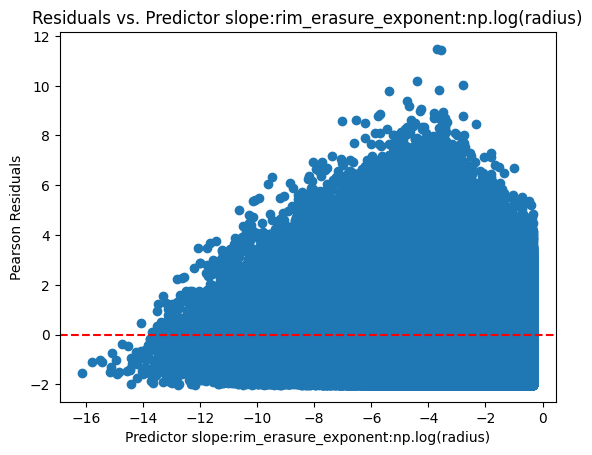

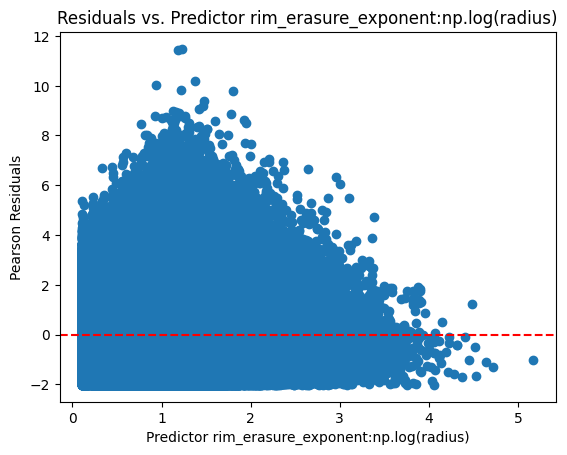

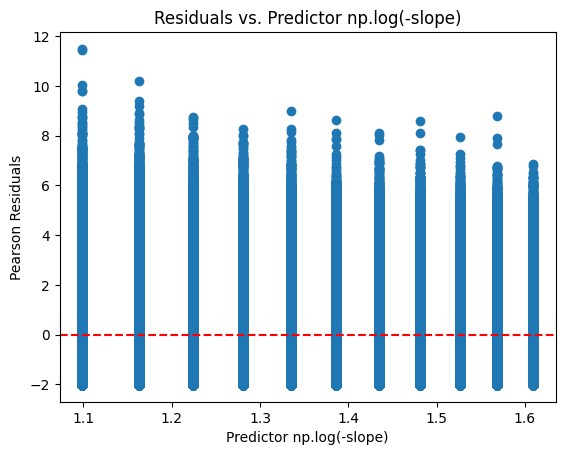

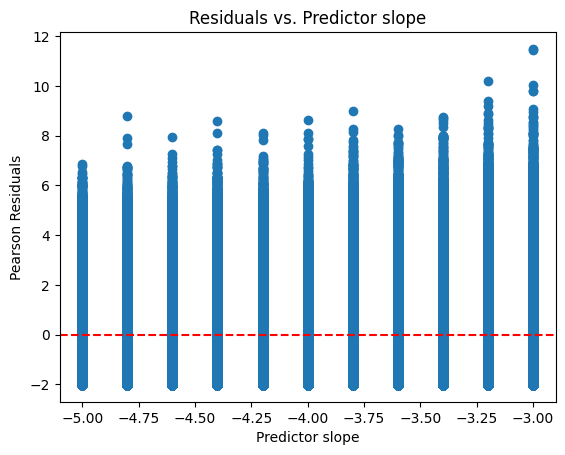

In [352]:
for i in range(1, len(model.model.exog_names) - 1):  # Skip the intercept and alpha
    plt.scatter(model.model.exog[:, i], pearson_residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(f"Predictor {model.model.exog_names[i]}")
    plt.ylabel("Pearson Residuals")
    plt.title(f"Residuals vs. Predictor {model.model.exog_names[i]}")
    plt.show()

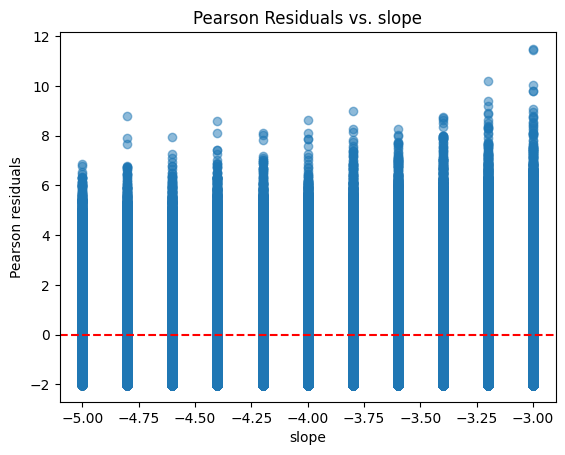

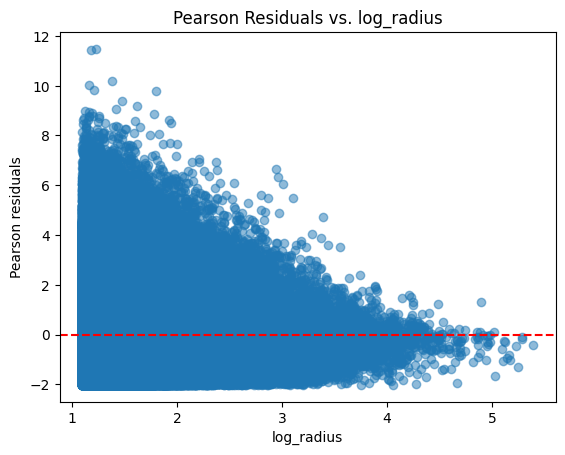

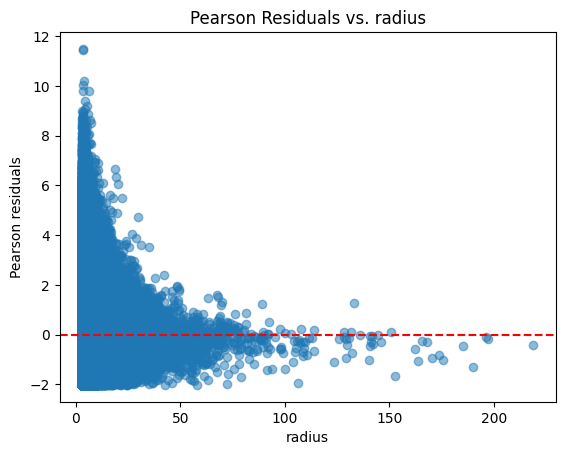

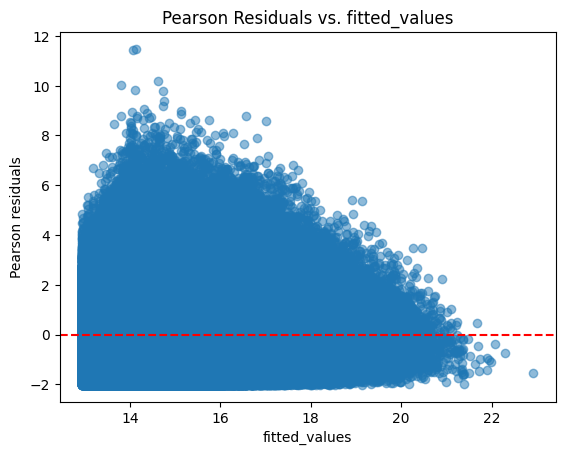

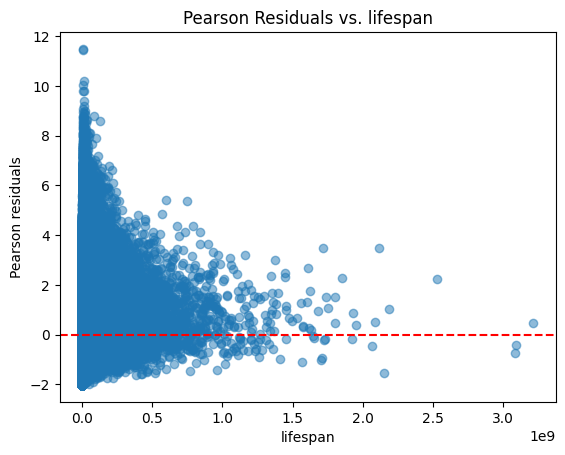

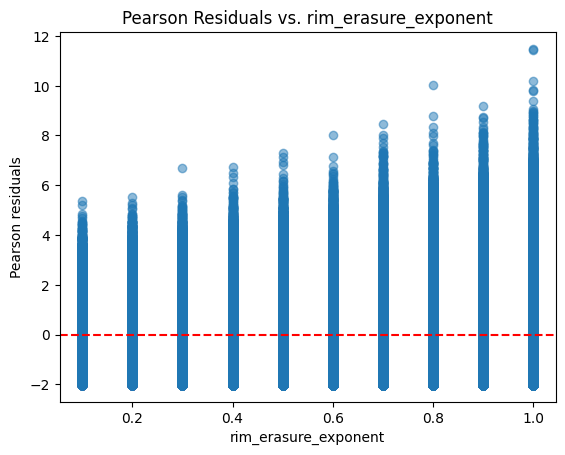

In [353]:
# Plot Pearson residuals vs fitted values
data["fitted_values"] = model.fittedvalues
data["log_fitted_values"] = np.log(model.fittedvalues)
data["log_radius"] = np.log(data.radius)
data["log_lifespan"] = np.log(data.lifespan)
var_names = ["slope", "log_radius", "radius", "fitted_values", "lifespan", "rim_erasure_exponent"]
for var_name in var_names:
    plt.scatter(data[var_name], model.resid_pearson, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel(var_name)
    plt.ylabel("Pearson residuals")
    plt.title(f"Pearson Residuals vs. {var_name}")
    plt.show()

In [370]:
# Let's check the whole range
max_slope = -1.99
min_slope = -7
data = df[(df.slope.between(min_slope, max_slope))].sample(frac=0.1).copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 14.744360
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:              1600000
Model:               NegativeBinomial   Df Residuals:                  1599995
Method:                           MLE   Df Model:                            4
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                 0.06422
Time:                        00:40:47   Log-Likelihood:            -2.3591e+07
converged:                       True   LL-Null:                   -2.5210e+07
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [371]:
# Let's check the whole range
max_slope = -0.1
min_slope = -7
data = df[(df.slope.between(min_slope, max_slope))].sample(frac=0.1).copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 13.874601
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:              2100000
Model:               NegativeBinomial   Df Residuals:                  2099995
Method:                           MLE   Df Model:                            4
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                 0.07737
Time:                        00:41:20   Log-Likelihood:            -2.9137e+07
converged:                       True   LL-Null:                   -3.1580e+07
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

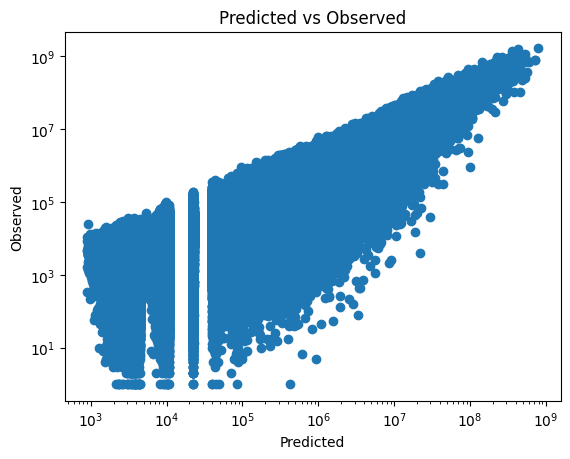

In [374]:
predicted = model.predict()
plt.scatter(predicted, model.model.endog)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Predicted vs Observed")
plt.xscale("log")
plt.yscale("log")
plt.show()

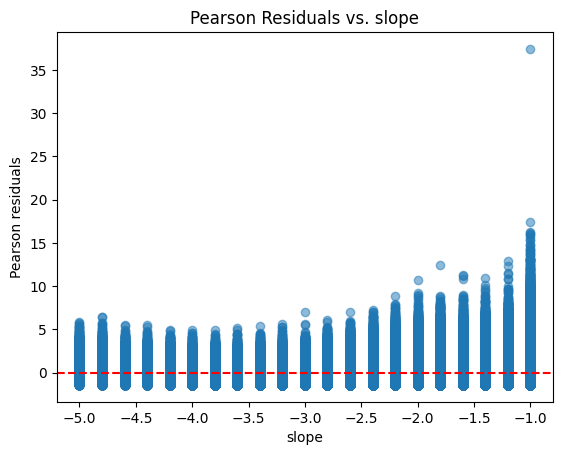

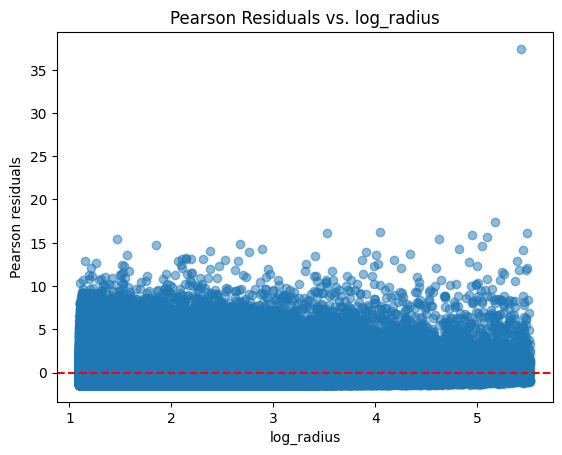

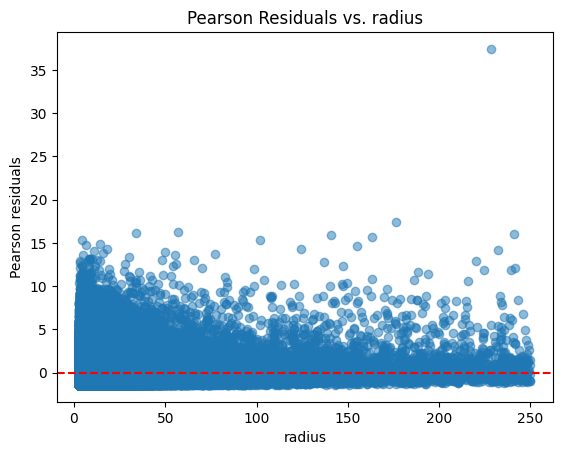

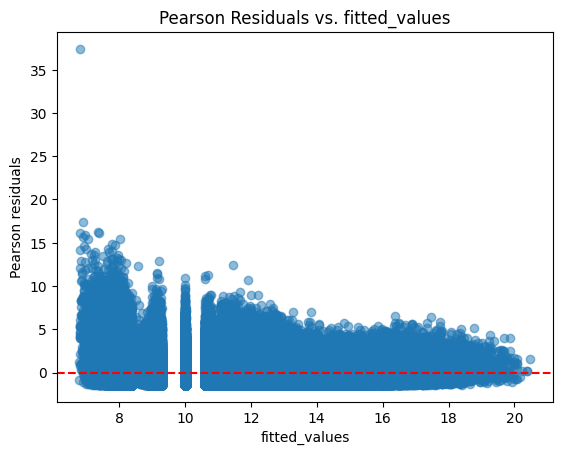

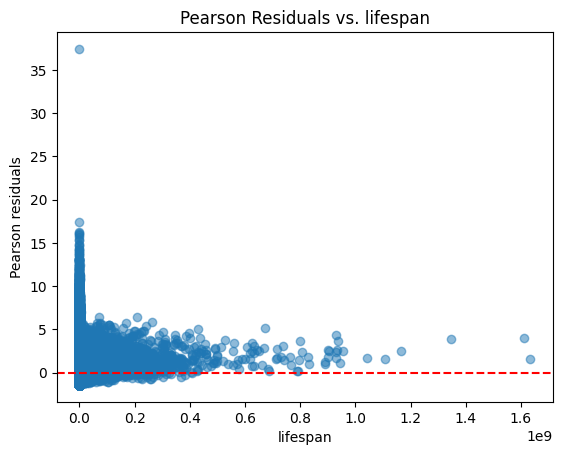

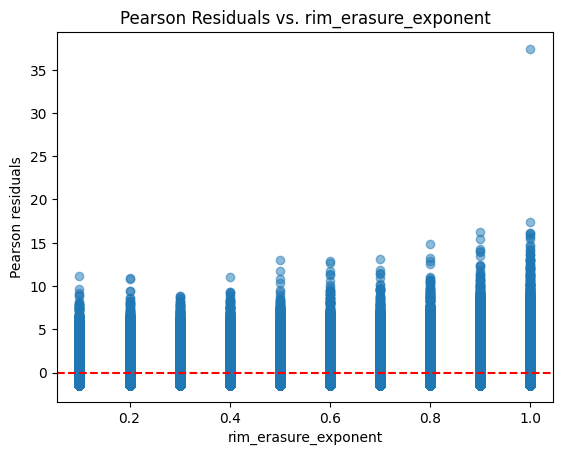

In [372]:
# Plot Pearson residuals vs fitted values
data["fitted_values"] = model.fittedvalues
data["log_fitted_values"] = np.log(model.fittedvalues)
data["log_radius"] = np.log(data.radius)
data["log_lifespan"] = np.log(data.lifespan)
var_names = ["slope", "log_radius", "radius", "fitted_values", "lifespan", "rim_erasure_exponent"]
for var_name in var_names:
    plt.scatter(data[var_name], model.resid_pearson, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel(var_name)
    plt.ylabel("Pearson residuals")
    plt.title(f"Pearson Residuals vs. {var_name}")
    plt.show()

### With Slopes >= -1.7

In [369]:
max_slope = -1.99
min_slope = -2.49
data = df[(df.slope.between(min_slope, max_slope))].sample(frac=0.1).copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 13.305459
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:               300000
Model:               NegativeBinomial   Df Residuals:                   299995
Method:                           MLE   Df Model:                            4
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                0.009043
Time:                        00:38:07   Log-Likelihood:            -3.9916e+06
converged:                       True   LL-Null:                   -4.0281e+06
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [364]:
max_slope = -0.5
min_slope = -1.8
data = df[(df.slope.between(min_slope, max_slope))].sample(frac=0.1).copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 10.803956
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:               500000
Model:               NegativeBinomial   Df Residuals:                   499995
Method:                           MLE   Df Model:                            4
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                 0.03754
Time:                        00:34:32   Log-Likelihood:            -5.4020e+06
converged:                       True   LL-Null:                   -5.6127e+06
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

## Shallow slope

In [ ]:
scenario_name = "shallow_slope"
selected_slope = -1
selected_mrp = 0.5
selected_rmult = 1.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = 1
filtered

In [ ]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
n_samples = 200
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
    & (F.col("ntot") < 5000)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[500, 1000, int(2.5*10**6)],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "dashed", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Steep slope

In [7]:
scenario_name = "steep_slope"
selected_slope = -4
selected_mrp = 0.5
selected_rmult = 1.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = 2
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
49,0.5,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.5,142.0,-4.0,250.0,2000.0
65,0.5,"{'name': 'radius_ratio', 'ratio': '5.0'}",1.5,2.0,-4.0,250.0,2000.0
106,0.5,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.5,146.0,-4.0,250.0,2000.0


In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
n_samples = 200
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
    & (F.col("ntot") < 5000)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

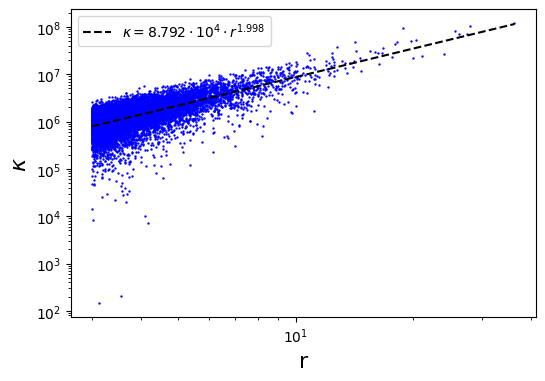

In [14]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [15]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                 2.109e+06
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:48:13   Log-Likelihood:            -2.0240e+06
No. Observations:             2500737   AIC:                         4.048e+06
Df Residuals:                 2500735   BIC:                         4.048e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.3842      0.002   6033.327      0.000      11.380      11.388
np.log(radius)     1.9984      0.001   1452.298      0.000       1.996       2.001
==============================================================================
Omnibus:                   956707.952   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8531527.971
Skew:                          -1.598   Prob(JB):                         0.00
Kurtosis:                      11.466   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
fitted_model = NegativeBinomial(lifetimes.lifetime, sm.add_constant(np.log(lifetimes.radius))).fit(maxiter=1000)

fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

Optimization terminated successfully.
         Current function value: 14.809171
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13


In [88]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               lifetime   No. Observations:               625184
Model:               NegativeBinomial   Df Residuals:                   625182
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                 0.03283
Time:                        18:20:55   Log-Likelihood:            -9.2585e+06
converged:                       True   LL-Null:                   -9.5727e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5045      0.003   3437.765      0.000      11.498      11.511
radius         1.9997      0.002    819.586      0.000       1.995       2.004
alpha          0.2328      0.000    580.165      0.000       0.232       0.234
==============================================================================
"""

In [79]:
np.log(0.1233)

np.float64(-2.0931348688118385)

In [33]:
lifetimes.lifetime.mean(), lifetimes.lifetime.var()

(np.float64(1779817.0306837545), np.float64(10734126701988.004))

In [ ]:
sorted_sampled = sampled.sort_values("radius")

n_chunks = 4
n_samples = sorted_sampled.shape[0] // n_chunks
ks_2samp(sorted_sampled.lifetime[:n_samples], sorted_sampled.lifetime[n_samples * (n_chunks - 2):n_samples * (n_chunks - 1)])

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[250, 5000, int(2.5*10**6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -4.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## High destruction, b = -2.5

In [89]:
scenario_name = "high_destruction"
selected_slope = -2.5
selected_mrp = 0.75
selected_rmult = 1.9

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = int(filtered.simulation_id.iloc[0])
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
60,0.75,"{'name': 'radius_ratio', 'ratio': '11.0'}",1.9,3.0,-2.5,250.0,2000.0


In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue",
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

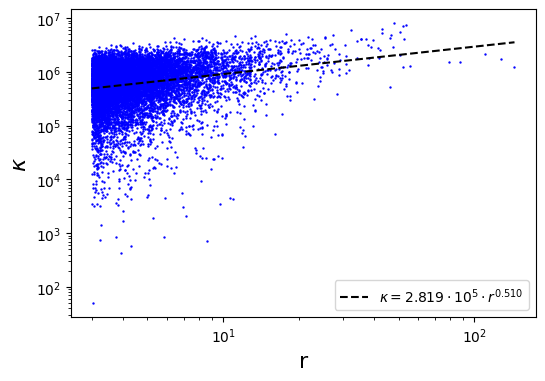

In [90]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [91]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                 1.250e+05
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:23:52   Log-Likelihood:            -3.3154e+06
No. Observations:             2501180   AIC:                         6.631e+06
Df Residuals:                 2501178   BIC:                         6.631e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.5493      0.002   5611.001      0.000      12.545      12.554
np.log(radius)     0.5100      0.001    353.600      0.000       0.507       0.513
==============================================================================
Omnibus:                   921017.545   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4759554.540
Skew:                          -1.713   Prob(JB):                         0.00
Kurtosis:                       8.825   Cond. No.                         8.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
%history -g -f history.txt

In [120]:
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial

# fitted_model = Poisson(lifetimes.lifetime, sm.add_constant(np.log(lifetimes.radius))).fit(maxiter=1000)
# fitted_model = NegativeBinomial(lifetimes.lifetime, sm.add_constant(np.log(lifetimes.radius))).fit(maxiter=1000)
fitted_model = smf.negativebinomial("lifetime ~ 1 + np.log(radius)", data=lifetimes).fit()

fitted_model.summary()

Optimization terminated successfully.
         Current function value: 14.505916
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               lifetime   No. Observations:              2501180
Model:               NegativeBinomial   Df Residuals:                  2501178
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                0.002950
Time:                        18:47:30   Log-Likelihood:            -3.6282e+07
converged:                       True   LL-Null:                   -3.6389e+07
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.8438      0.002   7161.984      0.000      12.840      12.847
np.log(radius)     0.5070      0.001    438.413      0.000       0.505       0.509
alpha              0.5337      0.000   1209.251      0.000       0.533       0.535
==================================================================================
"""

In [122]:
fitted_values

0          6.605205e+05
1          6.605205e+05
2          6.605207e+05
3          6.605208e+05
4          6.605209e+05
               ...     
2501175    8.079106e+06
2501176    8.102479e+06
2501177    8.156972e+06
2501178    8.258521e+06
2501179    8.720141e+06
Length: 2501180, dtype: float64

In [134]:
sm.genmod.families.family.NegativeBinomial(alpha=0.5337).deviance(
    endog=lifetimes.lifetime,
    mu=fitted_model.predict(lifetimes),  
) / fitted_model.df_resid

np.float64(1.0866958858252513)

In [125]:
np.sum(fitted_model.resid_pearson**2) / fitted_model.df_resid

np.float64(0.8141866241117914)

In [93]:
data = lifetimes

In [117]:
fitted_model.predict(data)

0          6.605205e+05
1          6.605205e+05
2          6.605207e+05
3          6.605208e+05
4          6.605209e+05
               ...     
2501175    8.079106e+06
2501176    8.102479e+06
2501177    8.156972e+06
2501178    8.258521e+06
2501179    8.720141e+06
Length: 2501180, dtype: float64

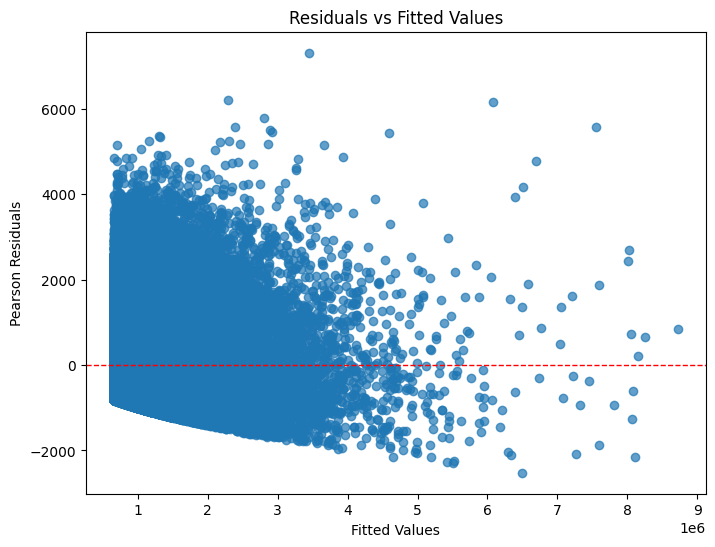

AttributeError: 'NegativeBinomialResults' object has no attribute 'mse_resid'

In [118]:
# 1. Residual Analysis
# Raw residuals
data['raw_residuals'] = data['lifetime'] - fitted_model.predict(data)

# Pearson residuals
data['pearson_residuals'] = data['raw_residuals'] / np.sqrt(fitted_model.predict(data))

# Deviance residuals
# data['deviance_residuals'] = fitted_model.resid_deviance

# Plot residuals against fitted values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_model.predict(data), data['pearson_residuals'], alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Fitted Values')
plt.ylabel('Pearson Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# 2. Leverage and Influence
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(fitted_model)
data['hat_values'] = influence.hat_matrix_diag
data['cooks_distance'] = influence.cooks_distance[0]

# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(data.index, data['cooks_distance'], markerfmt=",", use_line_collection=True)
plt.xlabel('Observation Index')
plt.ylabel('Cook\'s Distance')
plt.title('Cook\'s Distance for Each Observation')
plt.show()

# 3. Goodness-of-Fit
# Deviance and Pearson Chi-Square statistics
deviance = model.deviance
pearson_chi2 = np.sum(data['pearson_residuals']**2)
df_residual = model.df_resid

print(f"Deviance: {deviance}")
print(f"Pearson Chi-Square: {pearson_chi2}")
print(f"Degrees of Freedom: {df_residual}")
print(f"Deviance/DF: {deviance / df_residual:.2f}")
print(f"Pearson Chi-Square/DF: {pearson_chi2 / df_residual:.2f}")

# 4. Predicted vs Observed Counts
plt.figure(figsize=(8, 6))
plt.scatter(data['y'], model.fittedvalues, alpha=0.7)
plt.plot([min(data['y']), max(data['y'])], [min(data['y']), max(data['y'])], color='red', linestyle='--', linewidth=1)
plt.xlabel('Observed Counts')
plt.ylabel('Predicted Counts')
plt.title('Observed vs Predicted Counts')
plt.show()

# 5. Multicollinearity Diagnostics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add constant for VIF calculation
X = sm.add_constant(data[['x1', 'x2']])
vif = pd.DataFrame({
    'Variable': ['const', 'x1', 'x2'],
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[250, 5000, int(2.5*10**6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Low destruction, slope = -2.5

Ntot/nobs plot and Z/Za plots restricted in range to show Z/Za reaching significance before "saturation"

In [ ]:
scenario_name = "low_destruction"
selected_slope = -2.5
selected_mrp = 0.25
selected_rmult = 1.1

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = int(filtered.simulation_id.iloc[0])
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[500, 2500, 2500000],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "dashed", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## No erasure threshold, shallow slope

In [ ]:
scenario_name = "no_erasure_threshold_shallow_slope"
selected_slope = -1.0
selected_simulation_id = 139

# filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered = configs_pdf[configs_pdf.slope == selected_slope]
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4), dpi=400)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=10**7
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[1000, 1e6, int(10**7)],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## No erasure threshold, steep slope

In [ ]:
scenario_name = "no_erasure_threshold_steep_slope"
selected_slope = -4.0
# selected_slope = -3.5
selected_simulation_id = 142

# filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered = configs_pdf[configs_pdf.slope == selected_slope]
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# plt.figure(figsize=(6, 4), dpi=400)

# # Sampled scatterplot
# sampled = lifetimes.sample(frac=0.005)
# plt.scatter(
#     sampled.radius,
#     sampled.lifetime,
#     c="blue",
#     s=.5,
# )

# # Fit the line in log space
# fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
# fitted_intercept = np.exp(fitted_model.params.iloc[0])
# fitted_slope = fitted_model.params.iloc[1]

# plt.plot(
#     [sampled.radius.min(), sampled.radius.max()],
#     np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
#     ls="dashed",
#     c="black",
#     label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
# )

# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("r", fontsize=font_size)
# plt.ylabel("$\\kappa$", fontsize=font_size)
# plt.legend()

# plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
# plt.show()

In [ ]:
sorted_lifetimes = lifetimes.sort_values("radius")

n_samples_each = 1000
offset = sorted_lifetimes.shape[0] // 10
sample_sets = [
    sorted_lifetimes.lifetime[offset * x: offset * (x + 1)].sample(n_samples_each)
    for x in range(5)
]
result = anderson_ksamp(sample_sets)

print("Statistic:", result.statistic)
print("P-value:", result.pvalue)

if result.pvalue < 0.05:
    print("Reject the null hypothesis: The distributions are different.")
else:
    print("Fail to reject the null hypothesis: The distributions are not significantly different.")

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=10**7
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[1000, 1e6, int(10**7)],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Square root threshold function

In [7]:
scenario_name = "square_root_threshold"
selected_slope = -3.5
selected_simulation_id = 136

filtered = configs_pdf[configs_pdf.slope == selected_slope]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
10,0.5,"{'name': 'exponent', 'exponent': '0.9'}",1.5,120.0,-3.5,250.0,2000.0
22,0.5,"{'name': 'exponent', 'exponent': '0.6'}",1.5,117.0,-3.5,250.0,2000.0
61,0.5,"{'name': 'exponent', 'exponent': '0.7'}",1.5,118.0,-3.5,250.0,2000.0
63,0.5,"{'name': 'exponent', 'exponent': '0.1'}",1.5,112.0,-3.5,250.0,2000.0
66,0.5,"{'name': 'exponent', 'exponent': '0.8'}",1.5,119.0,-3.5,250.0,2000.0
89,0.5,"{'name': 'exponent', 'exponent': '0.3'}",1.5,114.0,-3.5,250.0,2000.0
99,0.5,"{'name': 'exponent', 'exponent': '0.2'}",1.5,113.0,-3.5,250.0,2000.0
114,0.5,"{'name': 'exponent', 'exponent': '0.5'}",1.5,116.0,-3.5,250.0,2000.0
118,0.5,"{'name': 'exponent', 'exponent': '0.4'}",1.5,115.0,-3.5,250.0,2000.0


24/12/06 08:35:19 WARN MemoryStore: Not enough space to cache rdd_34_147 in memory! (computed 87.7 MiB so far)
24/12/06 08:35:19 WARN BlockManager: Persisting block rdd_34_147 to disk instead.
24/12/06 08:35:19 WARN MemoryStore: Not enough space to cache rdd_34_149 in memory! (computed 87.3 MiB so far)
24/12/06 08:35:19 WARN BlockManager: Persisting block rdd_34_149 to disk instead.
24/12/06 08:35:19 WARN MemoryStore: Not enough space to cache rdd_34_141 in memory! (computed 153.2 MiB so far)
24/12/06 08:35:19 WARN BlockManager: Persisting block rdd_34_141 to disk instead.
24/12/06 08:35:19 WARN MemoryStore: Not enough space to cache rdd_34_157 in memory! (computed 83.9 MiB so far)
24/12/06 08:35:19 WARN BlockManager: Persisting block rdd_34_157 to disk instead.
24/12/06 08:35:19 WARN MemoryStore: Not enough space to cache rdd_34_151 in memory! (computed 86.2 MiB so far)
24/12/06 08:35:19 WARN BlockManager: Persisting block rdd_34_151 to disk instead.
24/12/06 08:35:19 WARN MemoryStore

nobs line: nan


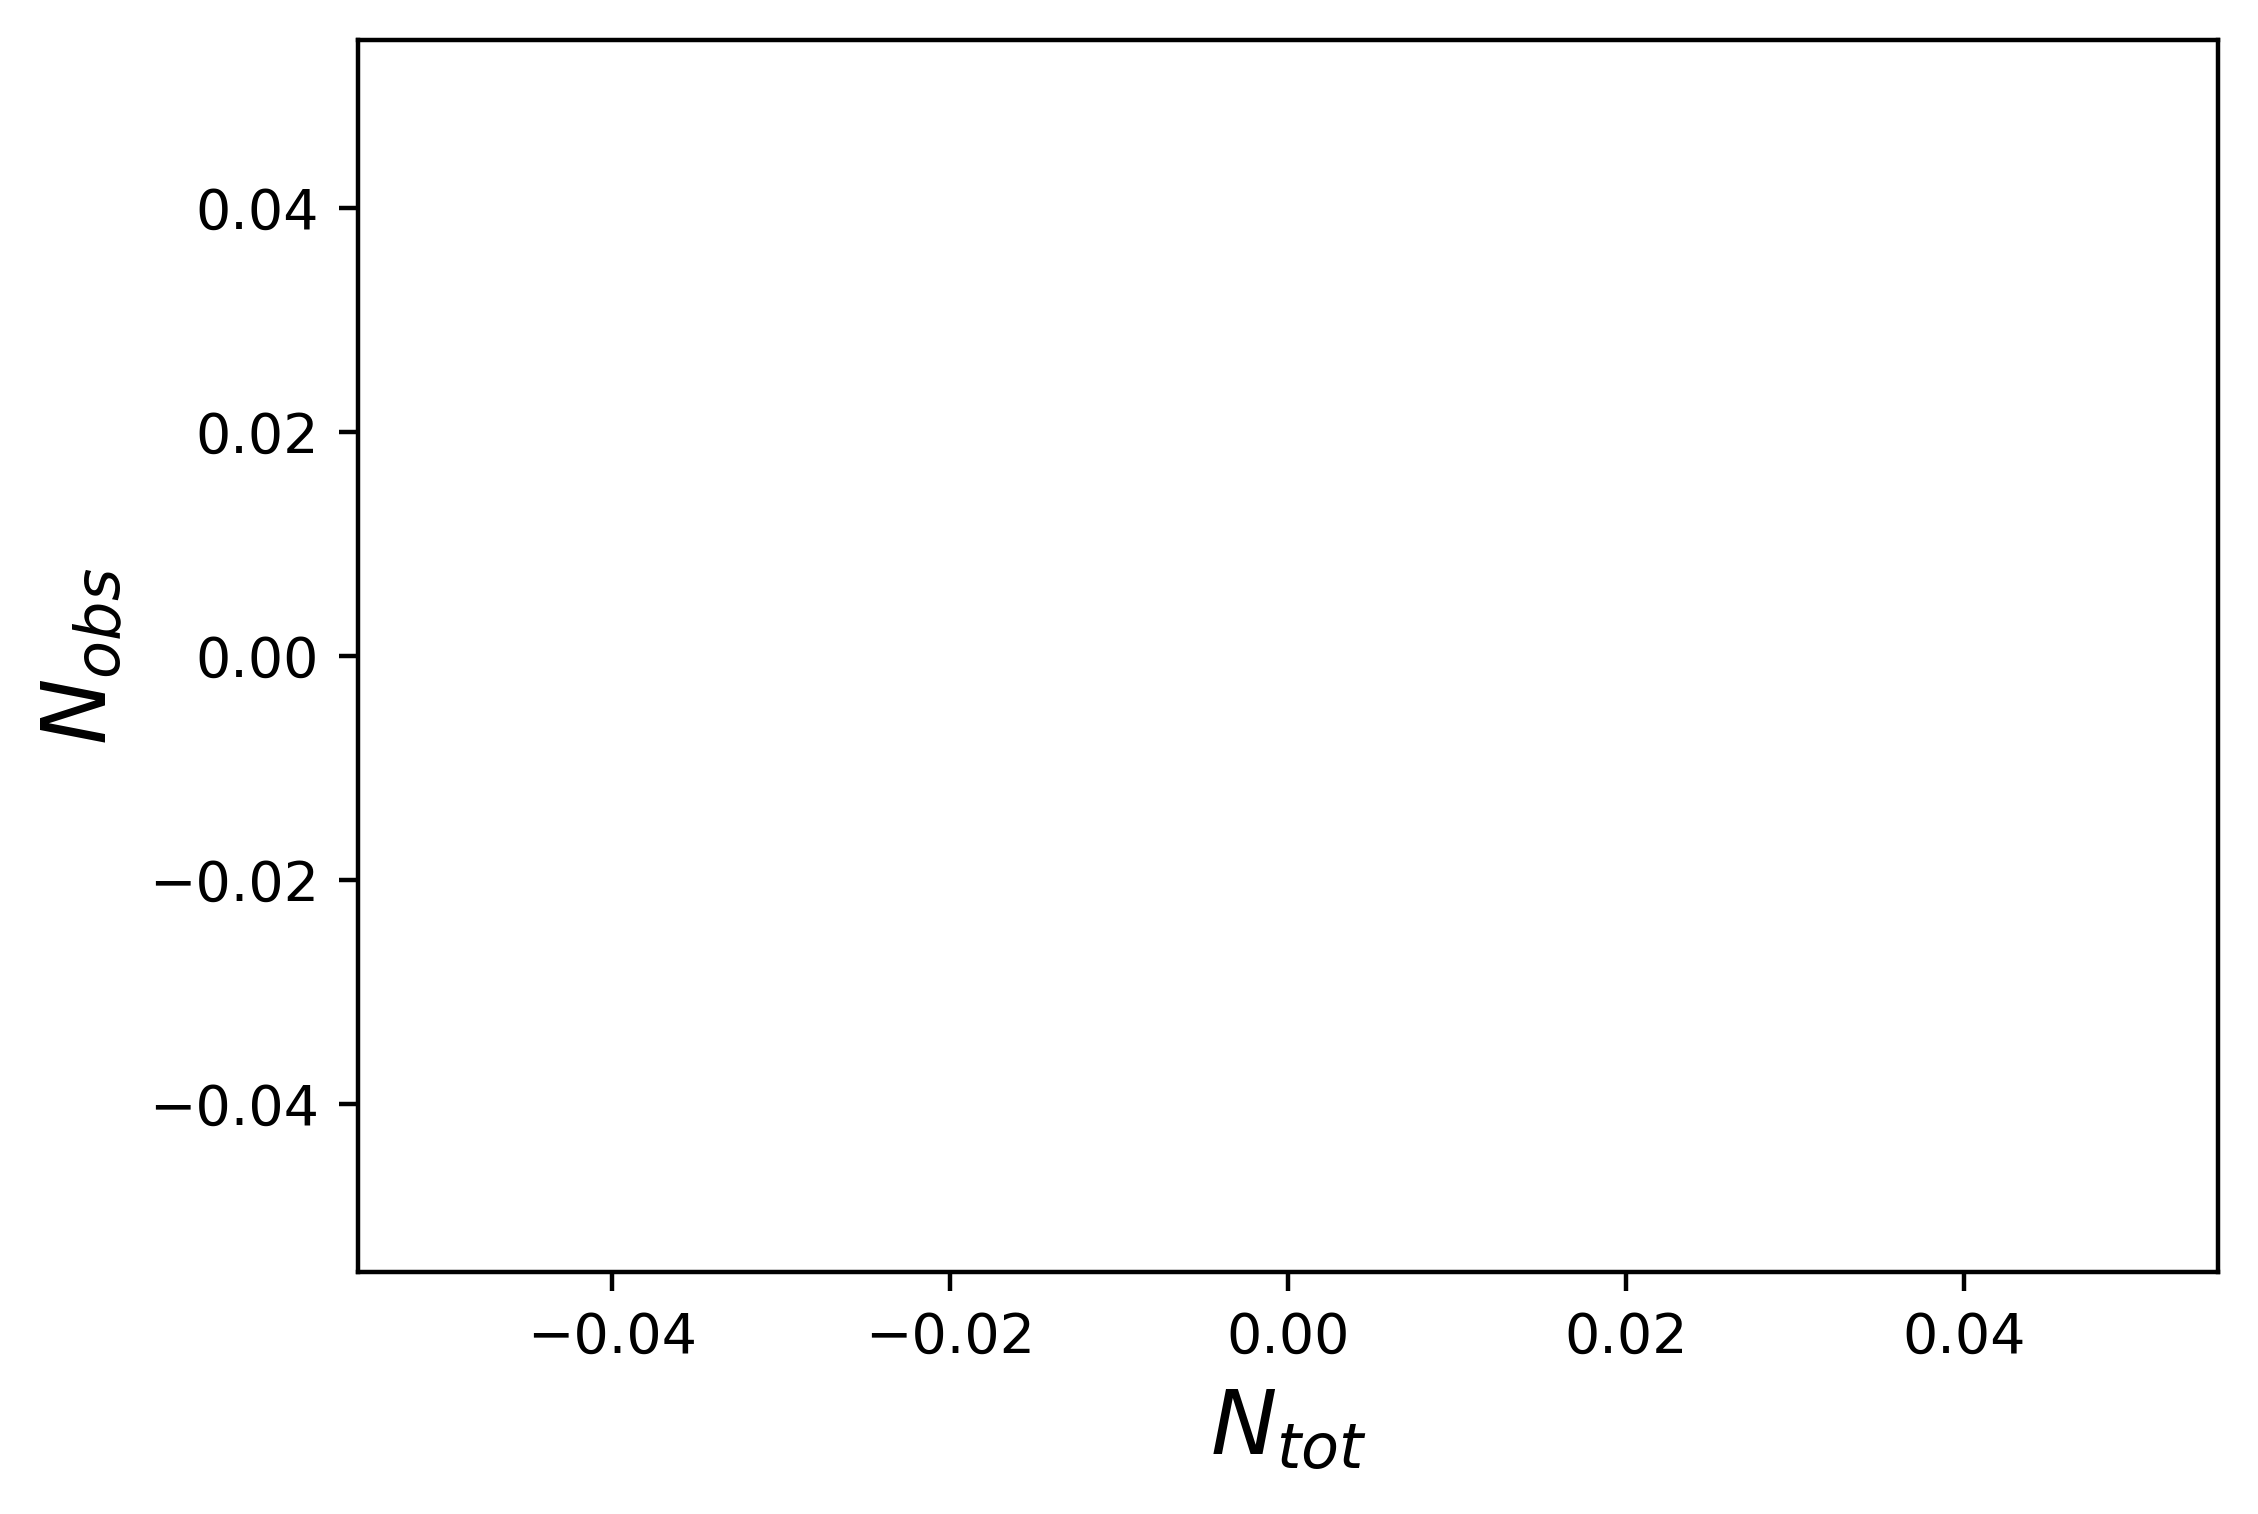

In [8]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4), dpi=400)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[1000, 1e6, int(2.5*10**6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -3.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Fourth root threshold function

In [ ]:
scenario_name = "fourth_root_threshold"
selected_slope = -3.5
selected_simulation_id = 137

filtered = configs_pdf[configs_pdf.slope == selected_slope]
filtered

In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4), dpi=400)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[1000, 1e6, int(2.5*10**6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -3.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Investigating lifetime for a range of slopes

In [17]:
scenario_name = "nu_vs_slope"
selected_simulation_ids = set(range(5, 110))

filtered = configs_pdf[configs_pdf.simulation_id.isin(selected_simulation_ids)].sort_values("simulation_id")
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
72,0.50,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.0,5.0,-1.000000,250.0,2000.0
52,0.50,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.0,6.0,-4.000000,250.0,2000.0
71,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,7.0,-5.000000,250.0,2000.0
70,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,8.0,-5.000000,250.0,2000.0
59,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,9.0,-5.000000,250.0,2000.0
...,...,...,...,...,...,...,...
9,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,105.0,-1.333333,250.0,2000.0
96,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,106.0,-1.333333,250.0,2000.0
3,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,107.0,-1.000000,250.0,2000.0
77,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,108.0,-1.000000,250.0,2000.0


In [18]:
sample_fraction = 0.25
craters_sampled = craters.where(F.col("simulation_id").isin(selected_simulation_ids)).sample(sample_fraction).cache()
removals_cached = removals.where(F.col("simulation_id").isin(selected_simulation_ids)).cache()

24/12/06 08:42:21 WARN CacheManager: Asked to cache already cached data.


In [19]:
all_lifetimes = dict()
all_models = dict()

for row in filtered.itertuples():
    lifetimes = get_lifetimes_for_simulation(
        simulation_id=row.simulation_id,
        craters=craters_sampled,
        removals=removals_cached,
        configs_df=configs_df,
        spark=spark
    )
    all_lifetimes[row.simulation_id] = lifetimes

    # Fit the line in log space
    # fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
    fitted_model = NegativeBinomial(lifetimes.lifetime, sm.add_constant(np.log(lifetimes.radius))).fit(maxiter=1000)
    all_models[row.simulation_id] = fitted_model

Optimization terminated successfully.
         Current function value: 9.991336
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.111625
         Iterations: 7
         Function evaluations: 58
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 15.036485
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 14.192090
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 14.226019
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 13.348599
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 15.000118
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
O

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.492254
         Iterations: 11
         Function evaluations: 107
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: 14.655277
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 16.265808
         Iterations: 8
         Function evaluations: 51
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 15.445829
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.455835
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.605017
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 16.232011
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 15.391660
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Opt

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 16.199011
         Iterations: 8
         Function evaluations: 58
         Gradient evaluations: 46


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.320684
         Iterations: 9
         Function evaluations: 64
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 15.376110
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.469579
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 16.166663
         Iterations: 12
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 15.242599
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 15.329999
         Iterations: 13
         Function evaluations: 78
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: 14.376998
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15


/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 16.132426
         Iterations: 9
         Function evaluations: 79
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: 15.139456
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 15.264316
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 14.262625
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 16.075630
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 15.000525
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Op

/home/mason/code/saturation/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 14.938048
         Iterations: 11
         Function evaluations: 70
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 13.890104
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 15.539533
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 14.490584
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 14.492540
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.561160
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
O

In [20]:
df = filtered.copy()
df["fitted_slope"] = [all_models[simulation_id].params.iloc[1] for simulation_id in df.simulation_id]
df["fitted_slope_std_err"] = [all_models[simulation_id].bse.iloc[1] for simulation_id in df.simulation_id]
df

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size,fitted_slope,fitted_slope_std_err
72,0.50,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.0,5.0,-1.000000,250.0,2000.0,-0.026455,0.001379
52,0.50,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.0,6.0,-4.000000,250.0,2000.0,-0.015330,0.001653
71,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,7.0,-5.000000,250.0,2000.0,2.993809,0.003643
70,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,8.0,-5.000000,250.0,2000.0,2.994658,0.006813
59,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,9.0,-5.000000,250.0,2000.0,2.993599,0.005007
...,...,...,...,...,...,...,...,...,...
9,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,105.0,-1.333333,250.0,2000.0,0.079330,0.002674
96,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,106.0,-1.333333,250.0,2000.0,-0.070086,0.002752
3,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,107.0,-1.000000,250.0,2000.0,0.079065,0.002116
77,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,108.0,-1.000000,250.0,2000.0,-0.107493,0.002223


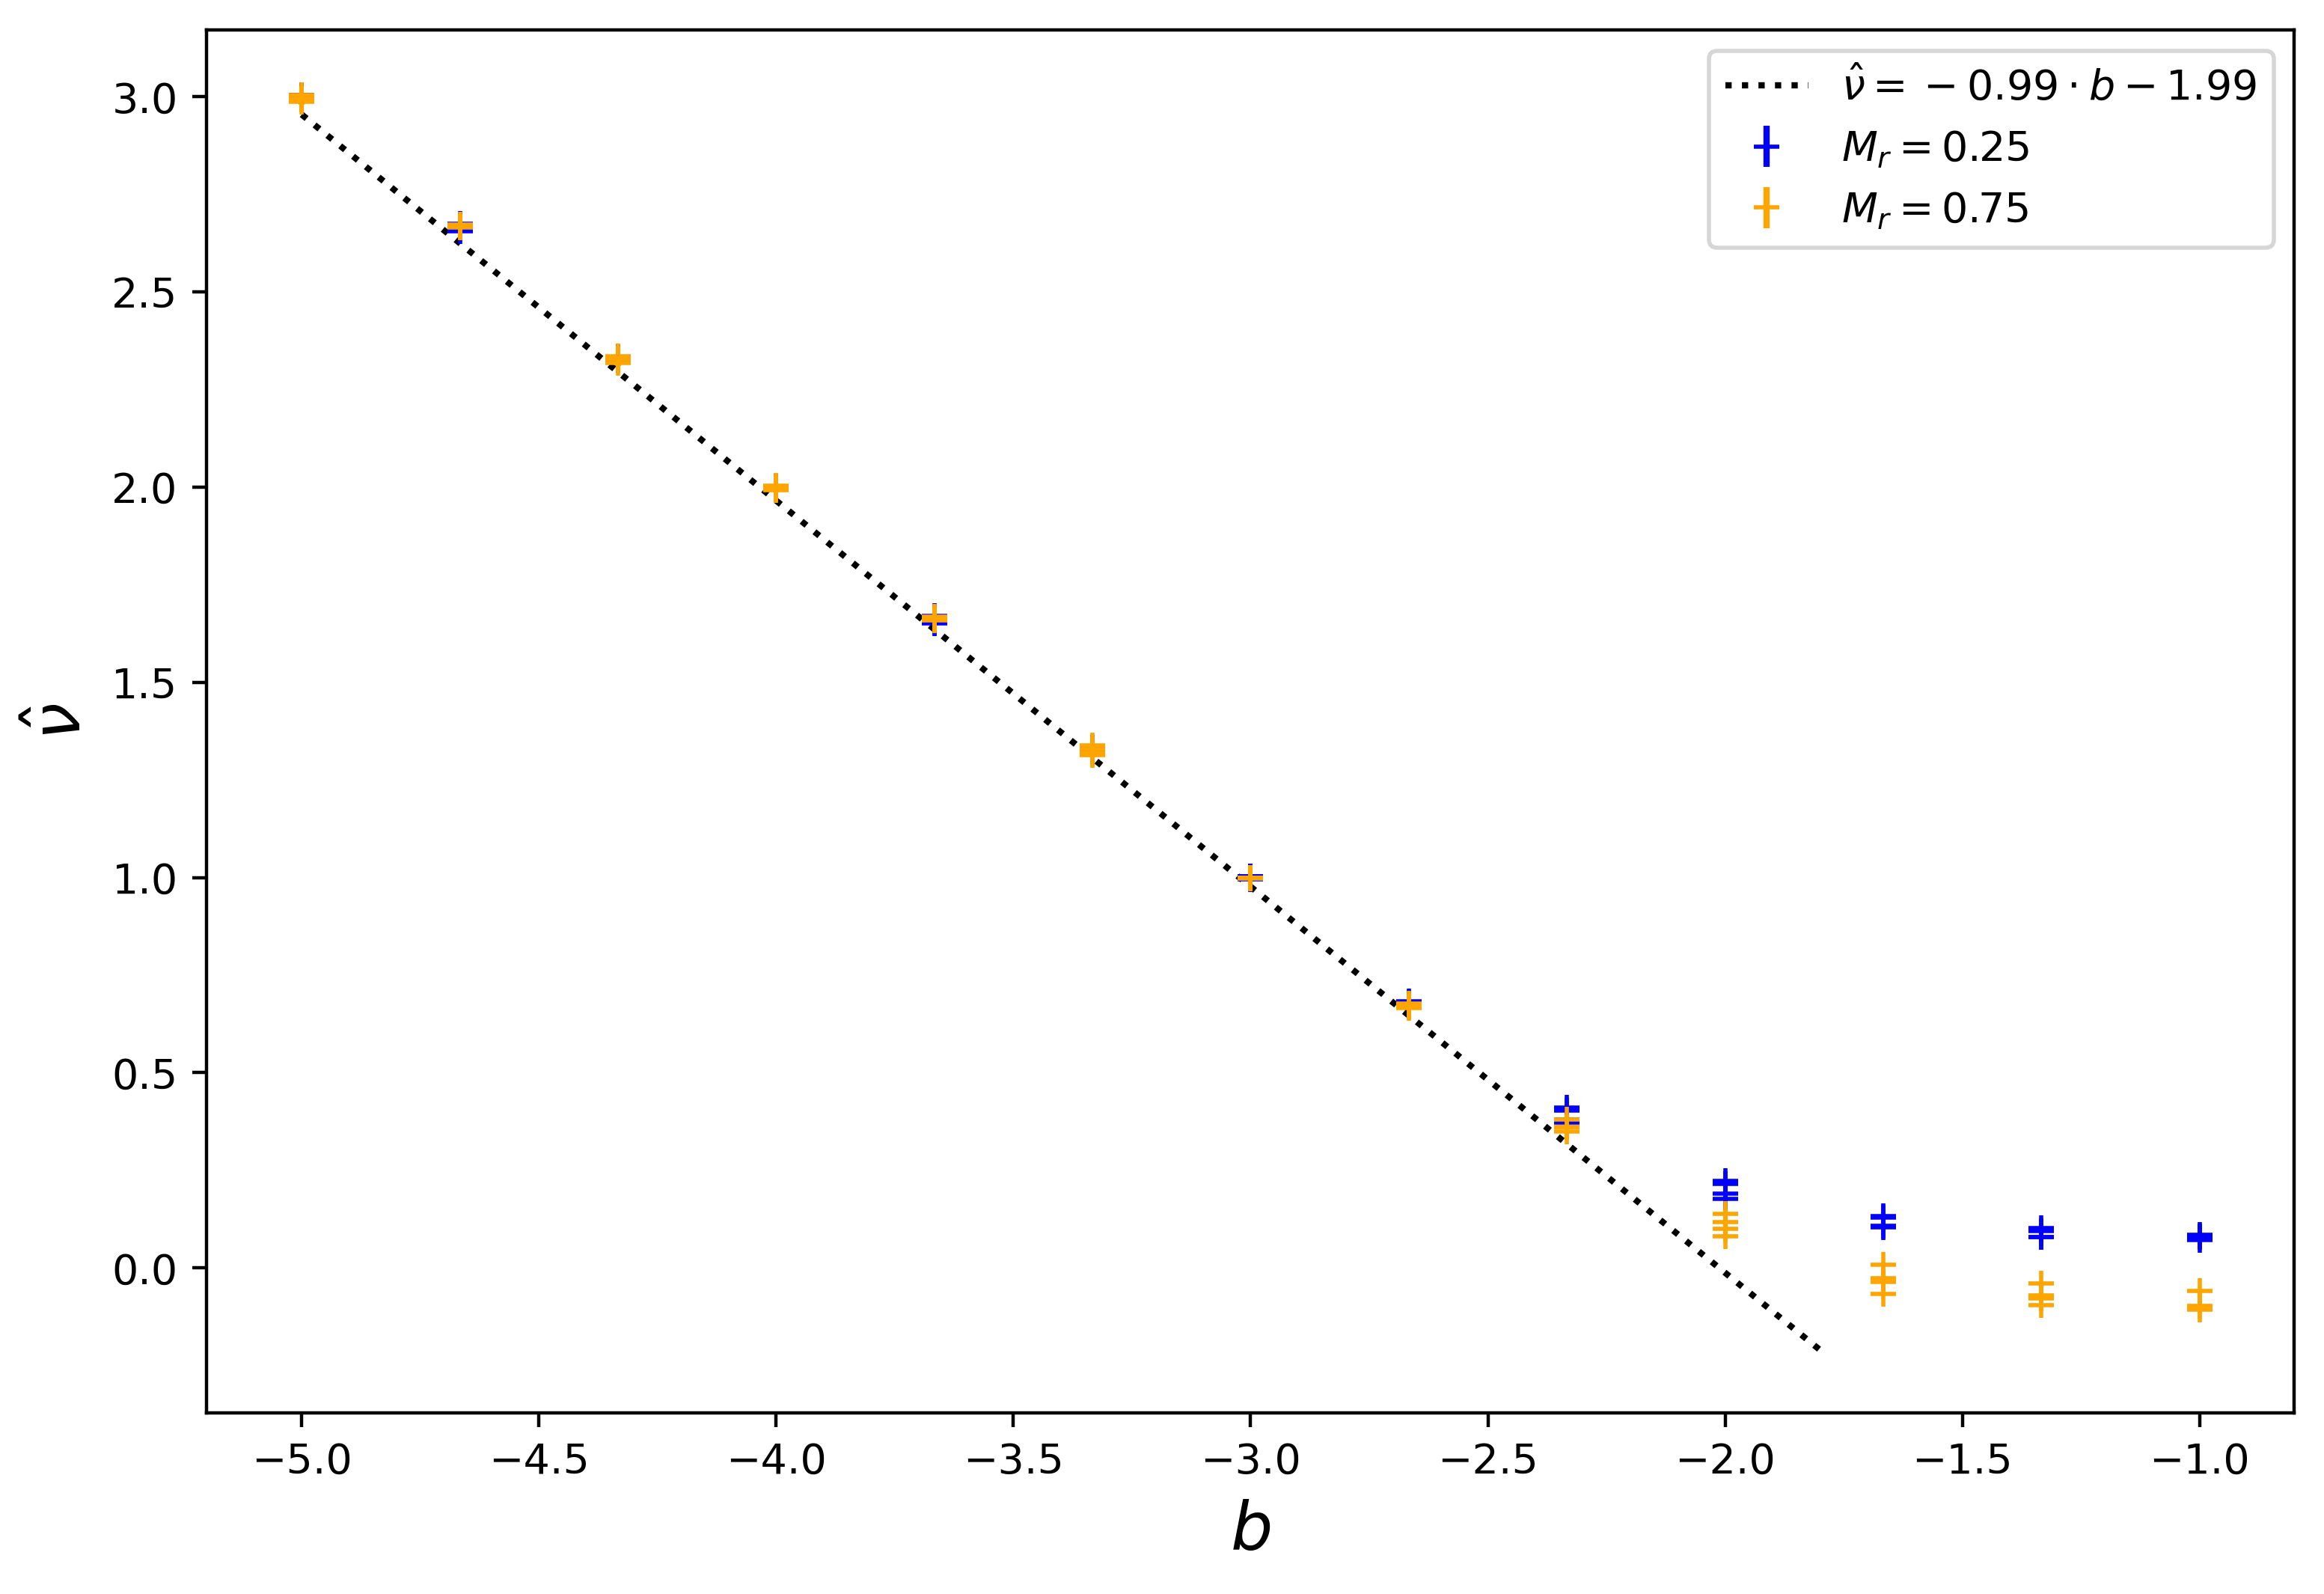

In [21]:
fig = plt.figure(figsize=(9, 6), dpi=400)
ax = fig.add_subplot(111)

low_mrp = df[df.mrp == 0.25]
ax.errorbar(
    low_mrp.slope,
    low_mrp.fitted_slope,
    low_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="b",
    label="$M_{r} = 0.25$"
)

high_mrp = df[df.mrp == 0.75]
ax.errorbar(
    high_mrp.slope,
    high_mrp.fitted_slope,
    high_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="orange",
    label="$M_{r} = 0.75$"
)

# Fit the line using OLS
steeper_slopes = df[df.slope < -2.5]
fitted_model = smf.ols(data=steeper_slopes, formula="fitted_slope ~ 1 + slope").fit()
fitted_intercept = fitted_model.params.iloc[0]
fitted_slope = fitted_model.params.iloc[1]

slopes_to_predict = pd.Series([-5.0, -1.8], name="slope")
ax.plot(
    slopes_to_predict,
    fitted_model.predict(slopes_to_predict),
    c="black",
    ls="dotted",
    label=f"$\\hat{{\\nu}} ={fitted_slope:.2f} \\cdot b - {-fitted_intercept:.2f}$"
)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\nu}$", fontsize=font_size)
ax.legend()

plt.savefig(f"figures/{scenario_name}_entire_range.png", bbox_inches="tight")
plt.show()

In [22]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fitted_slope   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     576.8
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           2.04e-33
Time:                        08:47:12   Log-Likelihood:                -1.5364
No. Observations:                  65   AIC:                             7.073
Df Residuals:                      63   BIC:                             11.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9901      0.161    -12.362      0.000      -2.312      -1.668
slope         -0.9889      0.041    -24.017      0.000      -1.071      -0.907
==============================================================================
Omnibus:                      142.443   Durbin-Watson:                   1.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10364.969
Skew:                          -7.857   Prob(JB):                         0.00
Kurtosis:                      62.834   Cond. No.                         21.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
craters_sampled.unpersist()
removals_cached.unpersist()

## Extended simulation, shallow slope

In [ ]:
scenario_name = "long_shallow_slope"
selected_slope = -1.0
selected_simulation_id = 135

filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered

In [ ]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters.where(F.col("simulation_id") == selected_simulation_id).sample(0.25),
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

plt.figure(figsize=(6, 4), dpi=400)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.001)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    [sampled.radius.min(), sampled.radius.max()],
    np.exp(fitted_model.predict(pd.Series([sampled.radius.min(), sampled.radius.max()], name="radius"))),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=50000000
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[500, 100000, int(5e7)],
    spark=spark
)

equilibrium_slope = -1.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "--", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "dotted", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")